<a href="https://colab.research.google.com/github/RezoanurRahman/Book_Recommender/blob/master/Book_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf



In [ ]:
book_db = pd.read_csv('books.csv')
rating_db = pd.read_csv('ratings.csv')

rating_db.head()
book_db.head()

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest= train_test_split(rating_db, test_size= 0.2, random_state=1)


In [ ]:
nbook_id = rating_db.book_id.nunique()
nuser_id = rating_db.user_id.nunique()


In [ ]:
input_books= tf.layers.Input(shape= 1)
input_embedbooks = tf.layers.Embedding(nbook_id+1, 15)(input_books)
output_books = tf.layers.Flatten()(input_embedbooks)
output_books.shape

TensorShape([None, 15])

In [ ]:
input_users= tf.layers.Input(shape= 1)
input_embedusers = tf.layers.Embedding(nuser_id+1, 15)(input_users)
output_users = tf.layers.Flatten()(input_embedusers)
output_users.shape

TensorShape([None, 15])

In [ ]:
mainembeddlayer = tf.layers.Concatenate()([output_users, output_books])
seconddenselayer= tf.layers.Dense(128,activation= 'relu')(mainembeddlayer)
finaldenselayer = tf.layers.Dense(1,activation='relu')(seconddenselayer)

model = tf.Model([input_users, input_books], finaldenselayer)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()


fitedmodel = model.fit([Xtrain.user_id,Xtrain.book_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.user_id, Xtest.book_id], Xtest.rating))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 15)        801375      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        150015      input_2[0][0]                    
_______________________________________________________________________________________

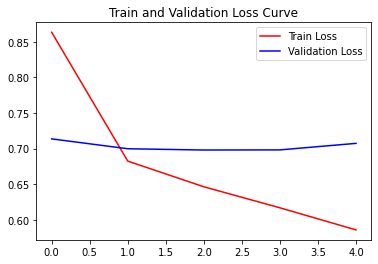

In [ ]:
train_loss = fitedmodel.history['loss']
val_loss = fitedmodel.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [ ]:
#save the model
model.save('model')

In [ ]:
book_em = model.get_layer('embedding_1')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [ ]:
books_df_copy = book_db.copy()
books_df_copy = books_df_copy.set_index("book_id")

b_id =list(rating_db.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [ ]:
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])

pred = model.predict([book_arr, user])
pred

In [ ]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([8047, 6989, 7324, 5707, 5847])

In [ ]:
book_db.iloc[pred_ids]

In [ ]:
web_book_data = book_db[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

In [ ]:
web_book_data.to_json(r'web_book_data.json', orient='records')